### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/800px-Markov_Decision_Process.svg.png' width=300px>
_img by MistWiz (Own work) [Public domain], via Wikimedia Commons_

In [43]:
# If you Colab, uncomment this please
# !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/week02_value_based/mdp.py

transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [44]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [45]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. For ubuntu just run:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [46]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


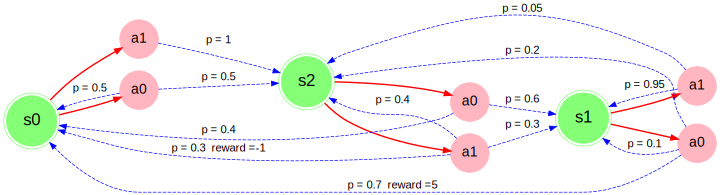

In [47]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, \
        plot_graph_optimal_strategy_and_state_values

    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [48]:
%%writefile mdp_get_action_value.py
#help(mdp.get_transition_prob)
import numpy as np
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    # YOUR CODE HERE
    q = 0
    for s1 in mdp.get_next_states(state, action).keys():
        p_value = mdp.get_transition_prob(state, action, s1)
        r = mdp.get_reward(state, action, s1)
        v = state_values[s1]
        q += p_value * (r + gamma * v)
    #print(q)
    return q

Overwriting mdp_get_action_value.py


In [49]:
from mdp_get_action_value import get_action_value

In [50]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.allclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

0.6900000000000002
3.9499999999999997


Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [51]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    # <YOUR CODE>
    v_list = []    
    for a in mdp.get_possible_actions(state):
        v_list.append(get_action_value(mdp, state_values, state, a, gamma))
    return max(v_list)

In [52]:
test_Vs_copy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 0.69)
assert test_Vs == test_Vs_copy, "please do not change state_values in get_new_state_value"

0.9
1.8
0.54
0.6900000000000002


Finally, let's combine everything we wrote into a working value iteration algo.

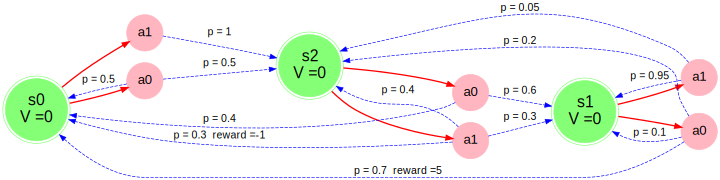

0.0
0.0
3.5
0.0
0.0
-0.3
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

0.0
0.0
3.815
2.9924999999999997
1.89
0.645
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

0.8504999999999999
1.7009999999999998
4.18355
3.346875
2.0601
1.41045
iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

1.6924949999999999
1.8540899999999998
5.318967499999999
3.66963975
2.8714770000000005
2.0304645
iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

2.1265051500000003
2.5843293000000007
5.663649635
4.676933677499999
3.5397148499999997
2.670457245
iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871

2.7558198675000005
3.185743365
6.27500459915
5.001707606174999
3.9887293509
3.2012516584500004
iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540

3.228512722155
3.58985641581
6.7897400170355
5.54462175306375
4.535370094

In [53]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    #<YOUR CODE HERE >
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values.keys()}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v)
                     for s, v in state_values.items()), end='\n\n')
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

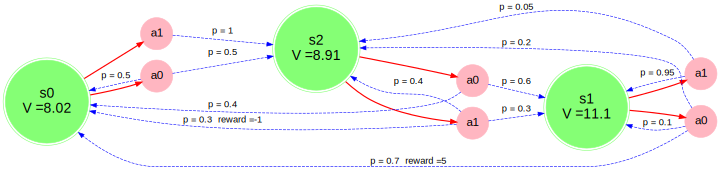

In [54]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [55]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032) < 0.01
assert abs(state_values['s1'] - 11.169) < 0.01
assert abs(state_values['s2'] - 8.921) < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [56]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    # <YOUR CODE HERE>
    a_list = []
    v_list = []
    for a in mdp.get_possible_actions(state):
        a_list.append(a)
        v_list.append(get_action_value(mdp, state_values, state, a, gamma))
    index = np.argmax(v_list)
    return a_list[index]

In [57]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

7.622407432642227
8.02400342848697
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885


7.622407432642227
8.02400342848697
7.622407432642227
8.02400342848697
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
8.916438974808628
8.08990200247885


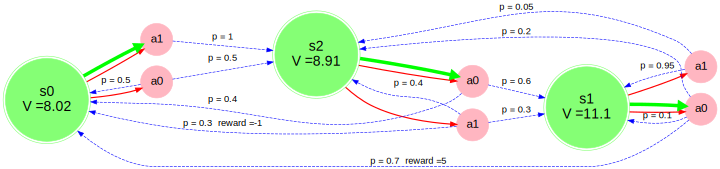

In [58]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError("Run the cell that starts with \"%%writefile mdp_get_action_value.py\"")

In [59]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.85 < np.mean(rewards) < 1.0)

7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407

8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.089902

8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.0240

8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.91643897

8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.91643897

8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945

11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697


### Frozen lake

In [60]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [61]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        # <YOUR CODE HERE >
        new_state_values =  {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values.keys()}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [62]:
state_values = value_iteration(mdp)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    3   |   diff: 0.72900   |   V(start): 0.00

In [63]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
down

SFFF
*HFH
FFFH
HFFG

0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
down

SFFF
FHFH
*FFH
HFFG

0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
right

SFFF
FHFH
F*FH
HFFG

0.6561000000000001
0.81
0.81
0.0
down

SFFF
FHFH
FFFH
H*FG

0.0
0.81
0.9
0.7290000000000001
right

SFFF
FHFH
FFFH
HF*G

0.81
0.9
1.0
0.81
right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0


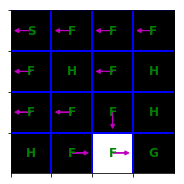

after iteration 1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    0   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81


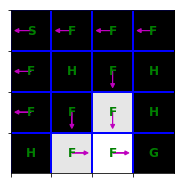

after iteration 2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


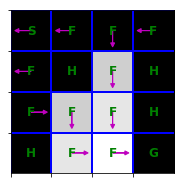

after iteration 3
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.7290000000000001
0.0
0.6561000000000001
0.6561000000000001
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.0
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


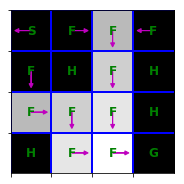

after iteration 4
0.0
0.0
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.7290000000000001
0.0
0.6561000000000001
0.6561000000000001
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.0
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.65610   |   V(start): 0.000 
0.0
0.5904900000000002
0.5904900000000002
0.0
0.0
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


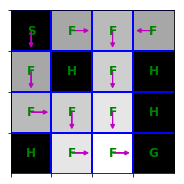

after iteration 5
0.0
0.5904900000000002
0.5904900000000002
0.0
0.0
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.59049   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.65

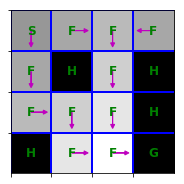

after iteration 6
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

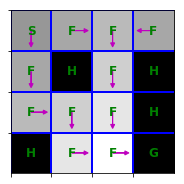

after iteration 7
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

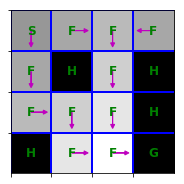

after iteration 8
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

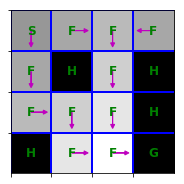

after iteration 9
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

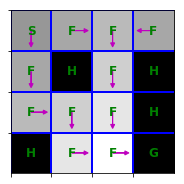

In [65]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
0.17858575307689448
0.18365563149921774
0.1981684335616138
0.17943944731585895
0.1808518808383202
0.20608047123182893
0.22234453053304482
0.20023934831224524
0.20299219638785357
0.23265650958286482
0.2493938602121421
0.22459789391663953
0.2278080301201617
0.26320597401522106
0.2796305131378171
0.25182518617611044
0.25621899039178686
0.3094394197274176
0.31337222528234676
0.28217342686289765
0.287159522081636
0.3479556234668964
0.3501900594269184
0.3153591444201669
0.32102931450672306
0.39118770221758725
0.3889979279563766
0.35215517800485857
0.3584501750270323
0.43410192748245174
0.3932106976185913
0.38876059453297834
0.18216594551015866
0.17276651928101178
0.20337356473110288
0.17999818659935574
0.18422070582900107
0.19150993908860311
0.22955578700659218
0.20092128163722212
0.20740143402928926
0.20783934739612847
0.25934276277310475
0.225554666736567
0.22265100685815614
0.02728695155877356
0.29368086707410623
0.25378766442781847
0.26866501782421737
0.331056913900833

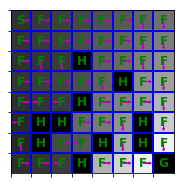

In [66]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [67]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    3   |   diff: 0.72900   |   V(start): 0.00

0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.72900000000000

0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.72900000000000

0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.

0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000

0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.590490000000000

0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0

0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.59049000000000

In [68]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05
0.9
0.05
iter    0   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04050000000000001
0.7290000000000001
0.04050000000000001
0.0
0.0
0.04050000000000001
0.7290000000000001
0.04050000000000001
0.04050000000000001
0.7790000000000001
0.9405
0.05
iter    1   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03280500000000001
0.5904900000000002
0.03280500000000001
0.0
0.0
0.0
0.0
0.0
0.03280500000000001
0.6232950000000002
0.6232950000000002
0.03280500000000001
0.042322500000000006
0.7618050000000001
0.042322500000000006
0.0
0.03280500000000001
0.6328125000000002
0.79461
0.042322500000000006
0.6656175000000002
0.8446100000000001
0.9

0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.6982959203451701
0.8296779101616557
0.07440940000895127
0.5790120144812692
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.

0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0

0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0

0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4195375965720586
0.04857823803558097
0.4998578589604756
0.453462776064271
0.46164653390395693
0.5893388231324447
0.461646533903957
0.5223514444065139
0.0638557428024403
0.6720390969294884
0.0638557428024403
0.4773642735144372
0.6982959203451701
0.8296779101616557
0.07440940000895127
0.5790120144812692
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.761

0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.6982959203451701
0.8296779101616557
0.

0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487


0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0

0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719


In [69]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.125
0.75
0.125
iter    0   |   diff: 0.75000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.084375
0.5062500000000001
0.084375
0.0
0.0
0.084375
0.5062500000000001
0.084375
0.084375
0.6312500000000001
0.834375
0.125
iter    1   |   diff: 0.50625   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.056953125000000014
0.34171875000000007
0.056953125000000014
0.0
0.0
0.0
0.0
0.0
0.056953125000000014
0.39867187500000006
0.39867187500000006
0.056953125000000014
0.0938671875
0.563203125
0.0938671875
0.0
0.056953125000000014
0.4355859375000001
0.6201562500000001
0.0938671875
0.49253906250000007
0.7451562500000001
0.9008203125
0.5236718750000001
iter    2   |   diff: 0.39867  

0.6425306405522481
0.7961252031655155
0.5592440396222572
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116

0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482

0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.279610158502

0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.12318176464887193
0.4769285942420417
0.12318176464887193
0.26216199365118986
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.559244039622

0.2616541192087085
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.12318176464887193
0.4769285942420417
0.12318176464887193
0.26216199365118986
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291

0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.796125203165

0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.2981816148116468
0.3246938

0.6727382003557169
0.5664926395359527
0.13535392859225082
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.12318176464887193
0.4769285942420417
0.12318176464887193
0.26216199365118986
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.1

In [70]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
iter    0   |   diff: 0.80000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.06408996252641565
0.06754625943360727
0.07619929395569959
0.05200521560535821
0.060943000133112595
0.08205194713417427
0.09222318173266088
0.01711654130093289
0.08911899857490635
0.09222318173266088
0.02418359274166497
0.11747941165896922
0.05332797839556942
0.4940244779080602
0.5925331843436079
0.0674006507435048
0.5425529406887305
0.671654063464487
0.7488961464912081
0.520676559761811
0.6183260850689176
0.8003676837105377
0.8791208791208791
0.1674006507435048
iter   15   |   diff: 0.02910   |   V(start): 0.087 
0.07912564459097339
0.08563940754695576
0.10597029748479345
0.08203005743923591
0.08579348330812317
0.11553580051225136
0.13982482517728181
0.1122730464549733
0.11904387398945945
0.14608482203755035
0.17130437567504167
0.14594954363081983
0.15276884322480253
0.17988895111654601
0.20322956463333314
0.17759505605026668
0.18621021195886983
0.22758178173922577
0.23563763698993428
0.20912125587893127
0.2182863757766417
0.2634263836746932
0.2679086019100563
0.2395328495240743
0.24

0.18794488619602714
0.21017333087412862
0.189450421430227
0.19653627380487576
0.23238369557795907
0.2396261263341861
0.21574775434456736
0.22394264286858576
0.26577552262669457
0.27001970913935136
0.24330626696385782
0.2528590651525336
0.3036217233189249
0.3013818803428328
0.27327640408028414
0.2839395627968789
0.3374123298902832
0.30826884207545374
0.30062987534782454
0.12113349403103055
0.11307533173993035
0.1355758450654222
0.12755296526344956
0.12429788403371977
0.12594976236226332
0.15562819576994696
0.1442156448380892
0.14131134214536153
0.13435219087698286
0.1790809172961494
0.16521306431220653
0.147852530864169
0.03976292933669048
0.2080819439509818
0.19108708982319816
0.1956667816908203
0.24009250559269354
0.26273142511716724
0.218368219398147
0.2414404424904721
0.27854304729365614
0.30122688676648673
0.2491789245228619
0.2796707885664039
0.3457679291028548
0.34250680263632494
0.2806828678559461
0.31962184782421976
0.38849902792252206
0.3503882624066126
0.309020847070462
0.109

0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.241

0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402

0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709

0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.28

0.21574859223636988
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.22136536526716916
0.05974344679813543
0.3108030703833323
0.27662689185980754
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12115388229951343
0.11310529753838539
0.13558726654469339
0.12756775355913186
0.12431585378724817
0.12596638979465968
0.15563

0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.879120

0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.239626595699

0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.28393975922

0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766


0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.2839397592277309
0.3374123981648326
0.30826895298348017
0.3006300045638942
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.18945204529

0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12115388229951343
0.11310529753838539
0.13558726654469339
0.12756775355913186
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.22136536526716916
0.05974344679813543
0.3108030703833323
0.27662689185980754
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.

0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701

0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.16260113512860766
0.8791208791208791
0.795568168095

0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402

0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956

0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709

0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.07778058189699655
0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.31132240162

0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.4094028

0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.046020321212645265
0.20696803491079094
0.2697985291034361
0.2171390867630689
0.22136536526716916
0.05974344679813543
0.3108030703833323
0.27662689185980754
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.403884332118595

0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332

## Bonus area

### Bonus 1 - find an MDP for which value iteration takes long to converge  (2+ pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

In [71]:
transition_probs = {
    < YOUR CODE >
}
rewards = {
    < YOUR CODE >
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

SyntaxError: invalid syntax (<ipython-input-71-5d8e1c813352>, line 2)

In [72]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
after iteration 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.2290478096056321
0.02737714957516801
0.15331513348915207
0.05314810252492802
0.3154749904650241
0.2275693175439361
0.2988389318353921
0.41471552135577616
0.07982173523404804
0.2786126596669441
0.13246450569252005
0.6955679229045122
0.6332718673892881
0.4893499630598402
0.0
0.0
0.0
0.0
0.0
0.010030613004288008
0.08024490403430407
0.010030613004288008
0.016439060201472008
0.0
0.016439060201472008
0.13151248161177606
0.10405997704972801
0.538807477810176
0.10405997704972801
0.2936723385876481
0.16260092021209602
0.879120875336552
0.7955679229045121
0.5799282370333201
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.053167310986752016
0.49268942262028814
0.591974788796928
0.067350934726272
0.5411067190928641
0.67109566413348
0.7487352338912641
0.5196265581039121
0.617928353146728
0.8003179374186881
0.879120875336552
0.167350934726272
N actions changed = 5 

after iteration 7
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.013792092880896

0.1328344161637297
0.6955681680956188
0.6336434971924277
0.4923094314713934
0.0415931714036613
0.05178476468848382
0.008892329627282078
0.027529082773867605
0.010284136119223675
0.09997411463503471
0.15189234156918616
0.01770102568124531
0.13185429204726482
0.013612408718227898
0.022955022301441627
0.1972525871297609
0.10501194345265237
0.5392051420074478
0.10501194345265237
0.3008904056137711
0.16260113512858726
0.879120879120879
0.7955681680956188
0.579929960149577
0.05774690962178837
0.06157427910323125
0.0733695477832742
0.04657796141317406
0.055612134169926705
0.07956607868045047
0.09018806365727969
0.016246281052528226
0.08721634246537383
0.09018806365727969
0.023896544837451572
0.11681424444931347
0.05332795127665685
0.4940242529641858
0.5925330932841046
0.06740064275093098
0.5425526966184989
0.6716539724049836
0.7488961193722756
0.5206763796320408
0.6183260211283268
0.8003676757179625
0.879120879120879
0.16740064275093097
N actions changed = 0 

after iteration 14
0.03056939199

0.01791156993516989
0.09196916445144172
0.09380644885976928
0.02443683962719375
0.11857134936384271
0.053327990168284246
0.4940245755894498
0.5925332241136908
0.06740065424317582
0.5425530466431658
0.67165410323457
0.7488961582639247
0.5206766377188919
0.6183261130662856
0.8003676872102087
0.8791208791208791
0.16740065424317582
N actions changed = 1 

after iteration 22
0.12407443758734328
0.12259368820193031
0.1394346978197248
0.12648029610417105
0.12791973220100059
0.14012449560592521
0.16030967825032694
0.1439692670636707
0.1475820618481721
0.16181359984207577
0.1836693653109376
0.1653011876153908
0.16963551004845945
0.18773913719891294
0.2100078893646795
0.1891518611971295
0.1962836898072175
0.23227337551170915
0.2395368584693673
0.2155911259472253
0.22381038311621804
0.26572281728917657
0.26997319372083917
0.24322192859938443
0.2527878238922533
0.3035961248800549
0.301357347949134
0.2732317731417252
0.28390224429237243
0.33739918918564127
0.30824736473638237
0.300604944037344
0.11

0.14785013229992633
0.03976260180382615
0.20808142396153864
0.19108556912724903
0.1956659359659806
0.24009222118800963
0.2627311442919005
0.2183674603827707
0.24144002184994182
0.27854292237520006
0.3012267620536871
0.2491785396294397
0.279670582681375
0.34576787245303187
0.34250674191887953
0.28068265812440096
0.3196217600747042
0.3884990038174663
0.35038821548674515
0.3090207412592575
0.109420116897301
0.10608314010963629
0.12019620046347705
0.1206505042970129
0.11275380169094734
0.11880199481638842
0.12752425476857973
0.13559972031729559
0.12745035308591154
0.1219190279726895
0.029831427964628447
0.14113712702465886
0.04602022348307794
0.2069679931420383
0.2697982900712822
0.21713831136963632
0.22136498605070057
0.05974339750811215
0.31080296637029475
0.27662648693250463
0.29538058214088897
0.39214146431745955
0.39401751413118197
0.3172269263956937
0.36516188331817906
0.4477986236919128
0.40388430170443057
0.3554826960082398
0.10311451563896945
0.09615372898944775
0.1153340741567895

0.09673695519098088
0.010377745286825012
0.013714992896380783
0.12009768845787128
0.05207157747150194
0.2714317329022178
0.32291056063237145
0.2128506326600151
0.27010884245348976
0.3722868630795682
0.37616525441357945
0.07138095239963577
0.31132240192563276
0.08757083714515373
0.47021113276512383
0.41143818726326037
0.44765754845116024
0.5968440472262299
0.5388332468729328
0.46807014814908604
0.07351874129360336
0.053590897061156426
0.01502601596344693
0.08124041197895812
0.017786562608292696
0.1719896083672302
0.2553634226154018
0.029697107500888636
0.21292361471634508
0.06059594686799566
0.32996786113224474
0.2930915504864939
0.31996020395790137
0.4179248759463571
0.08238334395079225
0.3005360906617581
0.13283684337092416
0.6955681680956406
0.6336459243997854
0.4923288491289681
0.06084383757392348
0.06380843740149732
0.014564531179036612
0.0642776386295173
0.010672046114413606
0.10316293152360155
0.15296454698075518
0.017786562608292696
0.13311718176615822
0.013766809216644266
0.022

0.16740065424400494
iter    0   |   diff: 0.00000   |   V(start): 0.141 
0.1262318964385328
0.12478139561944471
0.14077648432721507
0.12851690911107141
0.12985404187717525
0.14128630510281254
0.16097730066914032
0.14513383086266404
0.14858140030069544
0.16234326711463598
0.18400323240652044
0.16588597040234987
0.17012544086208498
0.18794610798211048
0.21017428960264478
0.18945217641005463
0.1965377407266326
0.23238432553144378
0.2396266333925675
0.21574865973937968
0.22394340608531837
0.26577582423964036
0.2700199738413682
0.24330674613806574
0.2528594681844713
0.30362186637695276
0.30138201764916345
0.2732766577617579
0.28393977503499873
0.33741240364806857
0.30826896187155833
0.30063001492683405
0.12115569563805528
0.11310801724220346
0.13558827125851278
0.12756902920463664
0.12431744593243274
0.12596786838046836
0.1556335149283106
0.14422405376524644
0.14131952173653922
0.1343592454067238
0.17908281117427155
0.16521677112887542
0.1478553100660521
0.039763308228602245
0.2080825278863

0.3108030745347585
0.2766269080330056
0.2953807514937081
0.392141504516346
0.3940175585087299
0.31722710669942417
0.3651619547925412
0.44779863983339263
0.40388433334630014
0.35548277719825583
0.10316411570594915
0.0962192534594028
0.11536207150556253
0.10918797502850507
0.1056444004324386
0.1071197824394873
0.13230367678035915
0.12174505399741306
0.11877054435905503
0.11448732413991775
0.15238884420753102
0.12964175108795242
0.10971996782919902
0.03608946596638761
0.17899575990190186
0.03608946596638761
0.1822207660906333
0.24860522208597613
0.05334381896126544
0.21036456638648937
0.07778058221630635
0.38505641335199314
0.44981576419890834
0.3301970398741081
0.4178851920589266
0.516715530531392
0.46605302381831537
0.4094028372057687
0.09162361513087289
0.07811248267012866
0.100716479042419
0.10267963349875463
0.08583666702424299
0.020049963869095848
0.09837770574874677
0.11530861114998772
0.0967371960043275
0.010377775003209702
0.013714995978649877
0.12009774283240872
0.05207157749076

0.6955681680956406
0.6336459244004484
0.4923288491342728
0.06084526854722673
0.06380885430373018
0.01456466494034795
0.06427861612077312
0.010672046159498776
0.10316293189485773
0.15296454711043897
0.017786562618867525
0.1331171819573952
0.013766809239939507
0.022982708037879124
0.1976284735429725
0.10501389307936973
0.5392052339520395
0.10501389307936973
0.3009059106829184
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.07106182666033896
0.07372056795106055
0.08058858174012022
0.06197739270506901
0.06646759559445177
0.08547555244875915
0.09382018601757165
0.017925018516107567
0.09198938933208986
0.09382018601757165
0.024438855399438283
0.1185782906610975
0.053327990171080836
0.4940245756126516
0.5925332241231203
0.06740065424400493
0.5425530466683353
0.6716541032439993
0.7488961582667214
0.5206766377374284
0.6183261130729185
0.8003676872110378
0.8791208791208791
0.16740065424400494
N actions changed = 0 

after iteration 62
0.12623189702567603
0.12478139

0.12756902976666235
0.12431744665298412
0.12596786905212928
0.15563351511166196
0.14422405404867472
0.14131952202604806
0.1343592456593116
0.17908281123663375
0.16521677124874504
0.14785531015725645
0.039763308240954774
0.20808252790414206
0.1910887967759961
0.1956676855971195
0.24009280791520124
0.26273172477397483
0.2183690359736014
0.24144091619184205
0.27854318794547894
0.3012270267608856
0.24917935545205416
0.2796710075079393
0.345767989453202
0.3425068675875731
0.2806830911214388
0.3196219463198393
0.3884990546492658
0.3503883132610053
0.30902096459744927
0.10948358857955215
0.10612888264656804
0.12023300247670661
0.12069174679127163
0.11281240496013081
0.11882400471762665
0.12753914905830457
0.13562148831509718
0.12747992057687532
0.1219259017780255
0.02983244899000538
0.14114555803873505
0.04602032521739574
0.20696803661003313
0.2697985388824288
0.21713911854539103
0.22136538040382844
0.05974344876520464
0.3108030745347681
0.27662690803304224
0.29538075149372306
0.3921415045163

0.4660530238183161
0.4094028372057709
0.09162361514422382
0.07811248268940266
0.10071647905015617
0.1026796335063861
0.08583666703496376
0.02004996387058823
0.0983777057504736
0.11530861115351436
0.09673719600923869
0.010377775003816293
0.013714995978708351
0.1200977428334831
0.052071577490767226
0.2714317329237918
0.3229105606872311
0.212850632801462
0.2701088425301712
0.3722868630952902
0.3761652544395331
0.07138095241237183
0.3113224019743657
0.08757083715026612
0.47021113278356697
0.41143818737348103
0.44765754848060124
0.5968440472300904
0.5388332468820981
0.46807014818383164
0.07351978313646662
0.05359229619079357
0.015026242466455016
0.08124102870834944
0.017786562618867525
0.17198960845396943
0.25536342264310136
0.029697107503029226
0.2129236147648838
0.06059594687324392
0.32996786114476917
0.2930915505680503
0.31996020397947533
0.4179248759484977
0.08238334395524155
0.3005360906994931
0.13283684337158724
0.6955681680956406
0.6336459244004484
0.4923288491342728
0.06084526854740

0.5925332241231203
0.06740065424400493
0.5425530466683353
0.6716541032439993
0.7488961582667214
0.5206766377374284
0.6183261130729185
0.8003676872110378
0.8791208791208791
0.16740065424400494
iter    0   |   diff: 0.00000   |   V(start): 0.141 
0.12623189702569418
0.12478139632370684
0.1407764846564591
0.12851690964465878
0.1298540423856271
0.14128630542164333
0.16097730081029923
0.1451338311246621
0.14858140051687785
0.16234326723018344
0.18400323246850375
0.16588597051712983
0.1701254409555757
0.18794610801986625
0.21017428963200185
0.18945217646392531
0.1965377407714177
0.23238432555059307
0.2396266334079846
0.21574865976708008
0.22394340610867963
0.26577582424887186
0.27001997384945586
0.2433067461526425
0.25285946819671207
0.30362186638128486
0.30138201765333095
0.27327665776950455
0.2839397750414875
0.33741240365031544
0.3082689618751895
0.30063001493107117
0.12115569646199437
0.1131080185037276
0.13558827171069246
0.12756902976666246
0.12431744665298428
0.12596786905212942
0.155

0.12747992057687543
0.12192590177802556
0.029832448990005395
0.1411455580387351
0.04602032521739574
0.20696803661003313
0.2697985388824288
0.21713911854539103
0.22136538040382844
0.05974344876520464
0.3108030745347681
0.27662690803304224
0.29538075149372306
0.39214150451634955
0.39401755850873377
0.31722710669944004
0.36516195479254765
0.447798639833394
0.403884333346303
0.35548277719826293
0.10316411571378427
0.09621925347083814
0.11536207150971535
0.10918797503595584
0.10564440043917012
0.10711978244511308
0.13230367678184185
0.12174505400145279
0.11877054436142578
0.11448732414164496
0.15238884420787055
0.12964175108942644
0.10971996782966681
0.036089465966446355
0.178995759901904
0.036089465966446355
0.1822207660906403
0.24860522208597777
0.05334381896126939
0.2103645663865201
0.07778058221630707
0.3850564133519936
0.44981576419890956
0.3301970398741137
0.41788519205892855
0.5167155305313923
0.4660530238183161
0.4094028372057709
0.09162361514422382
0.07811248268940266
0.10071647905

### Bonus 2 - Policy Iteration (3+ points)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [73]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [87]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    # YOUR CODE HERE
    print(policy)
    V_PI = {s:get_action_value(mdp, state_values, s, policy[s], gamma) for s in state_values.keys()}
    return V_PI

In [95]:
state_values = {s: 0 for s in mdp.get_all_states()}
test_policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 'a1', 's1': 'a1', 's2': 'a1'}
0.0
0.0
-0.3
{'s0': 0.0, 's1': 0.0, 's2': -0.3}


Once we've got new state values, it's time to update our policy.

In [96]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    #<YOUR CODE >
    new_policy = {s : get_optimal_action(mdp = mdp, state_values = state_values, state = s, gamma=gamma) for s in vpi.keys()}
    return new_policy

In [97]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

0.0
0.0
3.5
0.0
0.0
-0.3
{'s0': 'a0', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [100]:
def policy_iteration(mdp, state_values, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    #< A WHOLE LOT OF YOUR CODE >
    for n in range(num_iter):
        V_PI = compute_vpi(mdp, policy, gamma)
        policy = compute_new_policy(mdp, V_PI, gamma)
        
        # Compute difference
        diff = max(abs(V_PI[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
        print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()), end='\n\n')
        state_values = V_PI

        if diff < min_difference:
            print("Terminated")
            break

    return state_values, policy

__Your PI Results__

In [103]:
#< Compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake >
state_values = {s: 0 for s in mdp.get_all_states()}
policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}


for i in range(100):
    print("after iteration %i" % i)
    state_values,  new_policy =  policy_iteration(mdp, state_values, policy=policy, gamma=0.9, num_iter=1000, min_difference=1e-5)
    policy = new_policy

# run game
s = mdp.reset()
mdp.render()
for t in range(100):
    a = policy[s]
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    print(r)
    if done:
        break


after iteration 0
{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
0.0
3.5
0.0
0.0
0.0
3.5
0.0
0.0
-0.3
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
0.0
3.5
0.0
0.0
0.0
3.5
0.0
0.0
-0.3
iter    0   |   diff: 0.00000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

Terminated
after iteration 1
{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
0.0
3.815
1.89
0.0
0.0
3.815
2.9924999999999997
1.89
0.645
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
0.0
3.815
1.89
0.0
0.0
3.815
2.9924999999999997
1.89
0.645
iter    1   |   diff: 0.00000   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

Terminated
after iteration 2
{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
0.8504999999999999
4.18355
2.0601
0.8504999999999999
1.7009999999999998
4.18355
3.346875
2.0601
1.41045
iter    2   |   diff: 0.85050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

{'s0': 'a1', 's1': 'a0', 's2